# Setup

In [ ]:
!pip install wandb

import os
import PIL
import torch
import wandb
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from PIL import Image
from tqdm import tqdm
from torchvision.utils import make_grid
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.7/214.7 kB 19.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.4 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=e95bab8ee371513398ab00162020129649bc99bd5394a8d5bf07e4b8f1661431
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
## Visualization function
def show(tensor,num=16, wandbactive=0, name=''):
    tensor_data = tensor.detach().cpu()
    tensor_view = tensor_data[:num]
    grid = make_grid(tensor_view,nrow=4).permute(1,2,0)

    if (wandbactive==1 and wandbact==1): # wandbactive is for logging the image on wandb
        wandb.log({name:wandb.Image(grid.numpy())})

    plt.imshow(grid)
    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
wandbact = 1 # Track the stats through weights and biases.

cuda


# Setting up wandb for stats tracking

In [ ]:
wandb.login(key="")
experiment_name = wandb.util.generate_id()

myexp = wandb.init(
    project="wgan",
    group=experiment_name,
    config = {
        "optimizer":"Adam",
        "model":"wgan-gp",
        "epochs":"2000",
        "batch_size":256
    }
)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ruthvik_human (towardsintelligence). Use `wandb login --relogin` to force relogin


# The Generator

In [ ]:
## nn.ConvTranspose2d: (n-1)*stride - 2*padding + ks, n = width/height, k = kernel size

def gen_block(scale,kernel_size,stride,padding,z_dim=256,d_dim=16):
    return nn.Sequential(
        nn.ConvTranspose2d(z_dim, d_dim * scale, kernel_size, stride, padding),
        nn.BatchNorm2d(d_dim * scale),
        nn.ReLU()
    )

class Generator(nn.Module):
    def __init__(self,z_dim=256,d_dim=16):
        super(Generator,self).__init__()
        self.z_dim = z_dim
        self.d_dim = d_dim
        self.gen = nn.Sequential(
            gen_block(32,4,1,0,z_dim,d_dim), # size is 4 X 4 with 512 channels
            gen_block(16,4,2,1,d_dim*32,d_dim), # size is 8 X 8 with 256 channels
            gen_block(8,4,2,1,d_dim*16,d_dim), # size is 16 X 16 with 128 channels
            gen_block(4,4,2,1,d_dim*8,d_dim), # size is 32 X 32 with 64 channels
            gen_block(2,4,2,1,d_dim*4,d_dim), # size is 64 X 64 with 32 channels
            nn.ConvTranspose2d(d_dim*2,3,4,2,1), # size is 128 X 128 with 3 channels
            nn.Tanh()      # Produces an output in the -1,1 range
        )

    def forward(self,x):
        x = x.view(len(x), self.z_dim, 1, 1) # Image with z_dim channels with 1 X 1 spatial dimensions.
        return self.gen(x)

def gen_noise(batch_size,z_dim):
    return torch.randn(batch_size,z_dim).to(device)

In [ ]:
# gen = Generator().to(device)
# a = gen(gen_noise(128,256))
# show(a)

# The critic

In [ ]:
## nn.Conv2d: (n+2*pad-ks)//stride+1

def critic_block(i_dim,d_dim):
    return nn.Sequential(
        nn.Conv2d(i_dim,d_dim,4,2,1),
        nn.InstanceNorm2d(d_dim),
        nn.LeakyReLU(0.2)
    )

class Critic(nn.Module):
    def __init__(self,d_dim = 16):
        super(Critic,self).__init__()
        self.d_dim = d_dim
        self.critic = nn.Sequential(
            critic_block(3,d_dim), # Size is 64 X 64 with 16 channels
            critic_block(d_dim,d_dim*2), # Size is 32 X 32 with 32 channels
            critic_block(d_dim*2,d_dim*4), # Size is 16 X 16 with 64 channels
            critic_block(d_dim*4,d_dim*8), # Size is 8 X 8 with 128 channels
            critic_block(d_dim*8,d_dim*16), # Size is 4 X 4 with 256 channels
            nn.Conv2d(d_dim*16,1,4,1,0) # Size is 1 X 1 with 1 channel
        )

    def forward(self,x):
        critic_pred = self.critic(x)
        return critic_pred.view(len(critic_pred),-1) # batch_size X 1

In [ ]:
# crit = Critic().to(device)
# b = crit(a)

# The dataset

In [ ]:
class Celeb(Dataset):
    def __init__(self,path,size=128,lim=50000):
        super(Celeb,self).__init__()
        self.sizes = [size,size]
        images = []
        labels = []

        for data in os.listdir(path)[:lim]:
            new_path = os.path.join(path,data)
            images.append(new_path)
            labels.append(data)

        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self,idx):
        data = PIL.Image.open(self.images[idx]).convert('RGB')
        data = np.asarray(torchvision.transforms.Resize(self.sizes)(data))
        data = np.transpose(data, (2,0,1)).astype(np.float32)
        data = torch.from_numpy(data).div(255)
        return data, self.labels[idx]

In [ ]:
n_epochs = 2000
batch_size = 256
lr = 0.0001
z_dim = 256

cur_step = 0
crit_cycles = 5 # Train critic for 5 cycles and the generator for 1 cycle.
gen_losses = []
crit_losses = []
show_step = 50
save_step = 150

In [ ]:
path = "/content/drive/Othercomputers/My Laptop/celeb_subset"
train_dataset = Celeb(path)

train_dataloader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True, num_workers=2)

gen = Generator().to(device)
crit = Critic().to(device)
gen_optim = torch.optim.Adam(gen.parameters(),lr=lr,betas=(0.5,0.9))
crit_optim = torch.optim.Adam(crit.parameters(),lr=lr,betas=(0.5,0.9))

if (wandbact==1):
    wandb.watch(gen, log_freq=100)
    wandb.watch(crit, log_freq=100)

In [ ]:
root_path = "/content/drive/MyDrive/Colab Notebooks/data/"

def save_checkpoint(name):
    torch.save({
        'epoch':epoch,
        'model_state_dict':gen.state_dict(),
        'optimizer_state_dict':gen_optim.state_dict()
    }, f"{root_path}GG4-{name}.pth")

    torch.save({
        'epoch':epoch,
        'model_state_dict':crit.state_dict(),
        'optimizer_state_dict':crit_optim.state_dict()
    }, f"{root_path}CC4-{name}.pth")

    print("Checkpoint created successfully")


def load_checkpoint(name):
    checkpoint = torch.load(f"{root_path}GG3-{name}.pth")
    gen.load_state_dict(checkpoint['model_state_dict'])
    gen_optim.load_state_dict(checkpoint['optimizer_state_dict'])

    checkpoint = torch.load(f"{root_path}CC3-{name}.pth")
    crit.load_state_dict(checkpoint['model_state_dict'])
    crit_optim.load_state_dict(checkpoint['optimizer_state_dict'])

    print("Loaded checkpoint successfully")

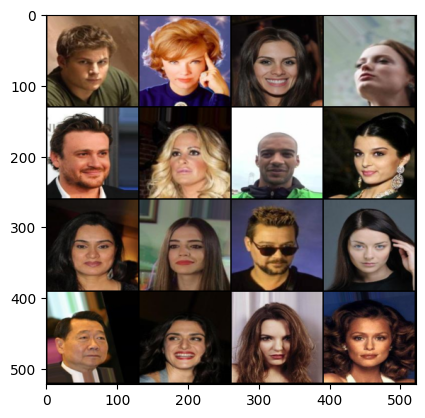

In [ ]:
img,label = next(iter(train_dataloader))
show(img)

In [ ]:
load_checkpoint("Latest")

Loaded checkpoint successfully


# Calculating the gradient penalty

In [ ]:
# ## gradient penalty calculation

# def get_gp(real, fake, crit, alpha, gamma=10):
#   mix_images = real * alpha + fake * (1-alpha) # 128 x 3 x 128 x 128
#   mix_scores = crit(mix_images) # 128 x 1

#   gradient = torch.autograd.grad(
#       inputs = mix_images,
#       outputs = mix_scores,
#       grad_outputs=torch.ones_like(mix_scores),
#       retain_graph=True,
#       create_graph=True,
#   )[0] # 128 x 3 x 128 x 128

#   gradient = gradient.view(len(gradient), -1)   # 128 x 49152
#   gradient_norm = gradient.norm(2, dim=1)
#   gp = gamma * ((gradient_norm-1)**2).mean()

#   return gp



In [ ]:
def get_gp(real,fake,critic,alpha,l=10):
    interpolated_imgs = alpha * real + (1-alpha) * fake
    outputs = critic(interpolated_imgs)
    gradients = torch.autograd.grad(
        inputs = interpolated_imgs,
        outputs = outputs,
        grad_outputs = torch.ones_like(outputs),
        retain_graph=True,
        create_graph=True,
    )[0]

    gradients = gradients.view(len(gradients),-1)
    gradient_norm = gradients.norm(2,dim=1)
    gp = l * ((gradient_norm - 1)**2).mean()
    return gp

# Training the WGAN

In [ ]:
# Loss function : -(E(D(x)) - E(D(G(z)))) for the critic
#                 - E(D(G(z))) for the generator

for epoch in range(n_epochs):
    for real,_ in tqdm(train_dataloader):
        cur_bs = len(real)
        real = real.to(device)

        ## Training the critic for crit_cycles
        mean_crit_loss = 0
        for _ in range(crit_cycles):
            crit_optim.zero_grad()
            noise = gen_noise(cur_bs,z_dim)
            fake_images = gen(noise)
            real_outputs = crit(real)
            fake_outputs = crit(fake_images.detach()) # detach() to save memory.

            alpha = torch.rand(len(real),1,1,1,device=device,requires_grad=True) # This is what indirectly makes the "interpolated_imgs" tensor have requires_grad=True.
            gp = get_gp(real,fake_images.detach(),crit,alpha)
            crit_loss = fake_outputs.mean() - real_outputs.mean() + gp
            mean_crit_loss += crit_loss.item()/crit_cycles

            crit_loss.backward()
            crit_optim.step()

        crit_losses+=[mean_crit_loss]

        ## Training the generator
        gen_optim.zero_grad()
        noise = gen_noise(cur_bs,z_dim)
        fake_outputs = crit(gen(noise))
        gen_loss = -1* fake_outputs.mean()

        gen_loss.backward()
        gen_optim.step()

        gen_losses+=[gen_loss.item()]

        ## Logging stats
        if (wandbact == 1):
            wandb.log({'Epoch':epoch, 'Step':cur_step,'Critic loss':mean_crit_loss,'Gen loss':gen_loss})


        if cur_step % save_step == 0 and cur_step > 0:
            print("Saving checkpoint: ",cur_step,save_step)
            save_checkpoint("Latest")

        if (cur_step % show_step == 0 and cur_step > 0):
            show(gen(noise),wandbactive=1,name='fake') # We are using the wandbactive to log the images on wandb
            show(real,wandbactive=1,name='real')

            gen_mean = sum(gen_losses[-show_step:])/show_step
            crit_mean = sum(crit_losses[-show_step:])/show_step
            print(f"Epoch: {epoch}: Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")

            plt.plot(
                range(len(gen_losses)),
                torch.Tensor(gen_losses),
                label= "Generator Losses"
            )

            plt.plot(
                range(len(crit_losses)),
                torch.Tensor(crit_losses),
                label= "Critic Losses"
            )
            plt.ylim(-500,500)
            plt.show()

        cur_step+= 1

  1%|          | 2/196 [02:18<3:44:14, 69.35s/it]


KeyboardInterrupt: ignored

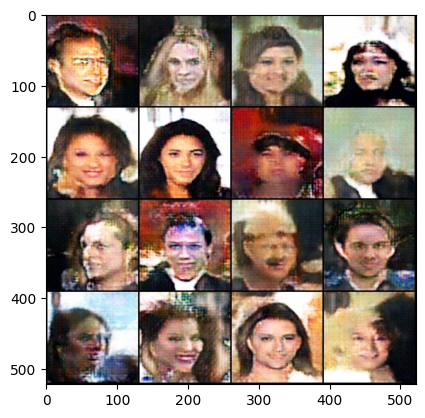

In [ ]:
show(gen(gen_noise(batch_size,z_dim)))